# **Heart Failure Classification**

## **Data Preparation Step**

* Import the needed libraries

In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from graphviz import Digraph
from IPython.display import display

* Load dataset from a CSV file

In [88]:
def load_data(file_path):
    return pd.read_csv(file_path)
data = load_data('heart.csv')

* Split the dataset into features (X) and target (y)

In [89]:
def split_features_target(df, target_column):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    return X, y

* Split dataset into training, validation, and test sets while maintaining class distribution

In [90]:
def split_train_validation_test(X, y, train_size=0.7, test_size=0.2, val_size=0.1, random_state=42):
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(1 - train_size), stratify=y, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(test_size / (test_size + val_size)), stratify=y_temp, random_state=random_state
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

In [91]:
def split_train_validation_test(X, y, train_size=0.7, test_size=0.2, val_size=0.1, random_state=42):
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(1 - train_size), stratify=y, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(test_size / (test_size + val_size)), stratify=y_temp, random_state=random_state
    )
    return X_train, X_val, X_test, y_train, y_val, y_test


* Print class distributions for training, validation, and test sets

In [92]:
def print_class_distribution(y_train, y_val, y_test):
    print("Training Class Distribution:\n", y_train.value_counts(normalize=True))
    print("Validation Class Distribution:\n", y_val.value_counts(normalize=True))
    print("Test Class Distribution:\n", y_test.value_counts(normalize=True))

* Perform one-hot encoding for categorical columns

In [93]:
def encode_categorical_columns(df, categorical_columns):
    return pd.get_dummies(df, columns=categorical_columns, dtype='uint8')

* Standardize numerical features using StandardScaler

In [94]:
def standardize_features(df):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

* Main

In [95]:
def main():
    # Load dataset
    df = load_data("heart.csv")
    print(df.head())
    
    # Split features and target
    X, y = split_features_target(df, 'HeartDisease')
    
    # Define categorical columns to encode
    categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
    df_encoded = encode_categorical_columns(X, categorical_columns)
    print("Encoded Columns:", df_encoded.columns)

    # Split data into train, validation, and test sets
    X_train, X_val, X_test, y_train, y_val, y_test = split_train_validation_test(df_encoded, y)
    
    # Validate class distribution
    print_class_distribution(y_train, y_val, y_test)
        
    # if needed, Standardize dataset
    df_standardized = standardize_features(df_encoded)
    print(df_standardized.head())
    return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = main()

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
Encoded Columns: Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA', 

## **Decision Tree**

### **Building the model**

In [96]:
class DecisionTreeNode:
    def __init__(
        self,
        feature: int | None = None,
        threshold: float | None = None,
        predicted_class: int | None = None,
        depth: int | None = None,
        left: "DecisionTreeNode | None" = None,
        right: "DecisionTreeNode | None" = None,
        entropy: float | None = None,
        samples: int = 0,
        values: dict[int, int] | None = None,
        feat_idx: int | None = None,
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.predicted_class = predicted_class
        self.depth = depth
        self.entropy = entropy
        self.values = values
        self.samples = samples
        self.feat_idx = feat_idx

    def __str__(self):
        return (
            f"{self.feature} <= {self.threshold}\n"
            f"Entropy = {self.entropy}\n"
            f"Samples = {self.samples}\n"
            f"Values = {self.values}\n"
            f"Class = {self.predicted_class}\n"
            f"Node Depth = {self.depth}\n"
        )

In [97]:
class DecisionTreeUtils:
    @staticmethod
    def information_gain(y : np.ndarray, y1 : np.ndarray, y2 : np.ndarray) -> float:
        y_entropy = DecisionTreeUtils.entropy(y)
        y_entropy_after_split_1 = DecisionTreeUtils.entropy(y1)
        y_entropy_after_split_2 = DecisionTreeUtils.entropy(y2)
        return (
            y_entropy
            - (len(y1) / len(y)) * y_entropy_after_split_1
            - (len(y2) / len(y)) * y_entropy_after_split_2
        )

    @staticmethod
    def entropy(y : np.ndarray) -> float:
        zeroes_number = (y == 0).sum()
        prob_zero = zeroes_number / len(y)
        prob_one = 1 - prob_zero
        probs = np.array([prob_one, prob_zero])
        return -1 * np.sum(probs * np.log2(np.where(probs == 0, 1, probs)))

In [98]:
class DecisionTreeBuilder:
    def __init__(self, max_depth: int = 4, min_samples_split: int = 1):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.utils = DecisionTreeUtils()

    def build_tree(self, X : np.ndarray, y : np.ndarray, curr_depth : int, columns: list) -> DecisionTreeNode:
        if (curr_depth == self.max_depth or len(set(y)) <= 1 or (self.min_samples_split is not None and self.min_samples_split > len(y))):
            return DecisionTreeNode(values= dict(Counter(y)), samples= len(y), entropy= round(self.utils.entropy(y), 3), predicted_class=Counter(y).most_common(1)[0][0], depth=curr_depth)

        feature, threshold = self._best_split(X, y)
        tree_node = DecisionTreeNode(values= dict(Counter(y)), samples= len(y), entropy= round(self.utils.entropy(y), 3), feature= columns[feature],threshold=threshold,depth=curr_depth, feat_idx= feature)

        mask = X[:, feature] <= threshold
        X_left_split = X[mask, :]
        y_left_split = y[mask]
        X_right_split = X[~mask, :]
        y_right_split = y[~mask]

        tree_node.left = self.build_tree(X_left_split, y_left_split, curr_depth + 1, columns)
        tree_node.right = self.build_tree(X_right_split, y_right_split, curr_depth + 1, columns)
        return tree_node

    def traverse_tree(self, x : np.ndarray, node : DecisionTreeNode) -> int: # returns a class (0/1)
        if node.predicted_class is not None:
            return node.predicted_class
        return self.traverse_tree(x, node.left) if x[node.feat_idx] <= node.threshold else self.traverse_tree(x, node.right)

    def _best_split(self, X : np.ndarray, y : np.ndarray) -> tuple[int, int]: # feature and thresold are integers
        unique_values_list = [np.unique(X[:, i]) for i in range(X.shape[1])]
        mid_points_list = [values[:-1] + np.diff(values) / 2 for values in unique_values_list]

        max_info_gain = {"infoGain": -float("inf"), "feature": -1, "threshold": None}
        for i in range(X.shape[1]):
            local_max_info_gain = { "infoGain": -float("inf"), "feature": -1, "threshold": None}
            for split in mid_points_list[i]:
                mask = X[:, i] <= split
                left_split = y[mask]
                right_split = y[~mask]

                info_gain = self.utils.information_gain(y, left_split, right_split)
                if info_gain > local_max_info_gain["infoGain"]:
                    local_max_info_gain = { "infoGain": info_gain, "feature": i, "threshold": split}

            if local_max_info_gain["infoGain"] > max_info_gain["infoGain"]:
                max_info_gain = local_max_info_gain

        return max_info_gain["feature"], max_info_gain["threshold"]

In [99]:
class DecisionTreeClassifier:
    def __init__(self, max_depth: int = 4, min_samples_split: int =10):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        self.builder = DecisionTreeBuilder(min_samples_split=min_samples_split, max_depth=max_depth)

    def fit(self, X : pd.DataFrame, y : pd.Series):
        X_np = X.to_numpy()
        y_np = y.to_numpy()
        self.root = self.builder.build_tree(X_np, y_np, 0, X.columns)

    def predict(self, X : pd.DataFrame) -> list[int]: # classification of each input
        X_np = X.to_numpy()
        predictions_list = [self.builder.traverse_tree(row, self.root) for row in X_np]
        return predictions_list

In [100]:
def plot_tree(model : DecisionTreeClassifier, dot : Digraph):
    def add_edges(node : DecisionTreeNode):
        if node:
            # Label each node with feature, threshold, class, and depth
            dot.node(str(id(node)), label=str(node))

            if node.left:
                dot.edge(str(id(node)), str(id(node.left)), label="T")  # Left child
                add_edges(node.left)
            if node.right:
                dot.edge(str(id(node)), str(id(node.right)), label="F")  # Right child
                add_edges(node.right)

    add_edges(model.root)
    display(dot)

### **Tuning Hyperparameters Using the Validation Set**

In [101]:
from copy import deepcopy
class HyperParameterTuner:
    def __init__(self, model : DecisionTreeClassifier):
        self.model = model

    def fine_tune(self, X_train : pd.DataFrame, y_train : pd.Series, X_val : pd.DataFrame, y_val : pd.Series, param_grid : dict[list[int], list[int]]) -> None:
        best_accuracy = 0
        best_params = None
        best_model = self.model
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                temp_model = DecisionTreeClassifier(max_depth, min_samples_split)
                temp_model.fit(X_train, y_train)

                y_pred = temp_model.predict(X_val)
                val_accuracy = accuracy_score(y_val, y_pred)
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = {'max_depth' : max_depth, 'min_samples_split': min_samples_split}
                    best_model = temp_model
                    print("current hyperparameters after fine tuning:", best_params, "accuracy:", best_accuracy)
                    print("---------------------------------------------------------------------------------------")
        return best_model, best_params

In [102]:
model = DecisionTreeClassifier()
fine_tuned_model = HyperParameterTuner(model)
param_grid = {
    "max_depth": [2, 3, 4, 5, 6, None],
    "min_samples_split": [2, 3, 4, 20, 30, 40],
}

best_model, best_params = fine_tuned_model.fine_tune(X_train, y_train, X_val, y_val, param_grid)
max_depth = best_params['max_depth']
min_samples_split = best_params['min_samples_split']
print(f"Fine-tuned to max_depth={max_depth}, min_samples_split={min_samples_split}")

current hyperparameters after fine tuning: {'max_depth': 2, 'min_samples_split': 2} accuracy: 0.8478260869565217
---------------------------------------------------------------------------------------
current hyperparameters after fine tuning: {'max_depth': 3, 'min_samples_split': 2} accuracy: 0.8695652173913043
---------------------------------------------------------------------------------------
current hyperparameters after fine tuning: {'max_depth': 5, 'min_samples_split': 2} accuracy: 0.8804347826086957
---------------------------------------------------------------------------------------
Fine-tuned to max_depth=5, min_samples_split=2


### **Evaluating the model**

{'Accuracy': 0.8315217391304348, 'F1-Score': 0.8426395939086294, 'Confusion Matrix': array([[70, 12],
       [19, 83]], dtype=int64)}


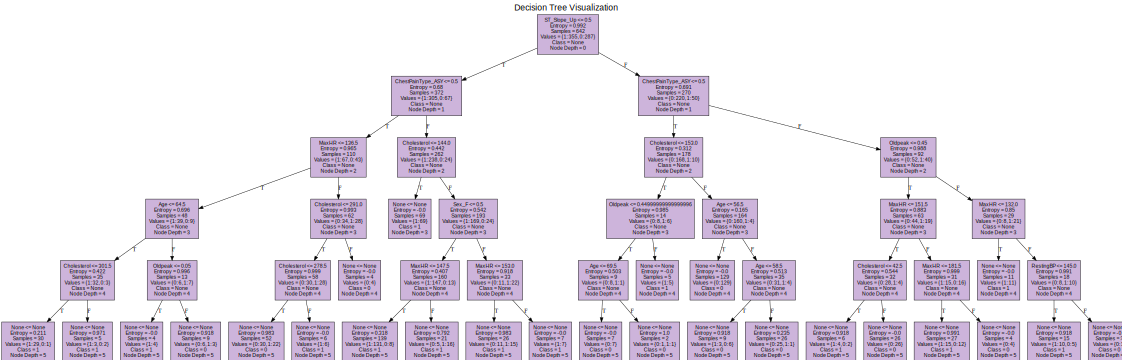

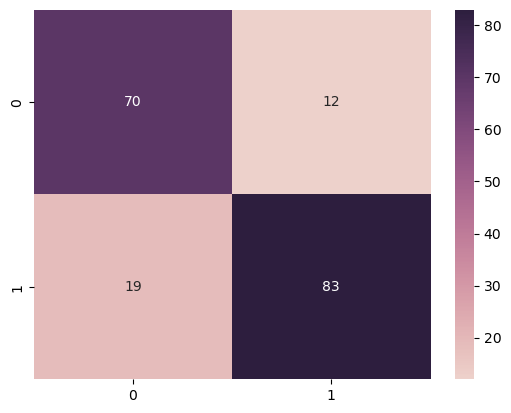

In [103]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
summary = {"Accuracy": test_accuracy, "F1-Score": f1, "Confusion Matrix": cm}
print(summary)
dot = Digraph()
dot.attr(size="25,5")
dot.attr(label="Decision Tree Visualization", labelloc="t", fontsize="20", fontname="Arial")
dot.attr("node", shape="box", width="0", height="0", margin="0.1", style="filled", fillcolor="#cdb4db", fontname="Arial", fontsize="12")
plot_tree(best_model, dot)